In [1]:
from tqdm import tqdm, tqdm_notebook
import newspaper
from time import time
import pandas as pd
import numpy as np
import langdetect
import stop_words
import spacy

tqdm.pandas()
tqdm_notebook()


0/|/| 0/? [00:00<?, ?it/s]

In [3]:
import csv
import codecs
with codecs.open('/Users/othmanayouche/Desktop/data_scraping.csv', 'r', 'latin') as csvFile:
    data = csv.reader(csvFile, delimiter=',', quotechar='"')
    df_comments = pd.DataFrame([row for row in data if len(row)==2 and row[0]!='source'], columns=['source', 'text'])

In [4]:
df_comments.source.value_counts().reset_index()

index  source
0          bestbuy   13281
1          youtube    8820
2           reddit    8441
3        gsm arena    5799
4          twitter    5016
5           amazon     842
6         flipkart     436
7             at&t     424
8      influenster     273
9  google shopping     156

In [5]:
# We clean the dataset by keeping english language and removing empty articles
def detect(text):
    try:
        return langdetect.detect(text)
    except langdetect.detector.LangDetectException:
        return np.nan

In [6]:
df_comments['lang'] = df_comments.text.progress_map(detect)

100%|██████████| 43488/43488 [04:26<00:00, 163.04it/s]


In [7]:

df_comments_clean = df_comments

In [8]:
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 10)

In [9]:
STOPWORDS = stop_words.get_stop_words(language='en')

In [10]:
# For the LDA model to be more efficient, we keep only the nouns in the comments, and reviews which have more than 8 nouns
nlp = spacy.load('en')
df_comments_clean['nlp_spacy'] = df_comments_clean.text.progress_map(lambda comment: nlp(comment.lower()))
df_comments_clean['noun_tokens'] = df_comments_clean.nlp_spacy.progress_map(
    lambda n: [w.lemma_ for w in n if w.pos_=='NOUN'])
df_comments_clean['noun_tokens_len'] = df_comments_clean['noun_tokens'].map(len)
df_try = df_comments_clean.loc[df_comments_clean.noun_tokens_len>=8]

100%|██████████| 43488/43488 [00:01<00:00, 36299.26it/s]


In [11]:
# Bigram and trigram for meaningful combination of 2/3 words
bigram = Phrases(df_try.noun_tokens.tolist(), min_count=3)
trigram = Phrases(bigram[df_try.noun_tokens.tolist()], min_count=3)

/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [12]:
sw = ['iphone', 'phone', '+', 'gb', 'edge', 'one', 'galaxy', 'samsung', 'galaxy_s8', 'plus', 
      's5', 'series', 'x', 'x.', '5s', '6s', '7', '8+', 'android', 'apple', 'ios', 'iâ\x80\x99m', 
      's4', 's5', 's6', 's7', 's8', 'bestbuy', 'best_buy', 'wife', 'son', 'daughter']
tokens = list(trigram[bigram[df_try.noun_tokens.tolist()]])
tokens = [[t for t in tok if t.lower() not in STOPWORDS+sw] for tok in tokens]
tokens =[[t for t in tok if t.lower() not in STOPWORDS+sw] for tok in tokens]
id2word_newspaper = corpora.Dictionary(tokens)
id2word_newspaper.filter_extremes(no_below=3)
corpus = [id2word_newspaper.doc2bow(tok) for tok in tokens]

In [13]:
#Create different topics using LDA Model
num_topics = 10
np.random.seed(42)
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=id2word_newspaper, \
                                  passes=4, alpha=[0.0001] * num_topics, eta = [0.0001] * len(id2word_newspaper.keys()))


/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 13.7 s, sys: 90.4 ms, total: 13.8 s
Wall time: 13.3 s


In [14]:
lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=True)

[(0,
  '0.069*"app" + 0.047*"camera" + 0.043*"screen" + 0.021*"picture" + 0.020*"feature" + 0.020*"bixby" + 0.018*"time" + 0.018*"photo" + 0.017*"button" + 0.016*"thing"'),
 (1,
  '0.051*"screen" + 0.037*"size" + 0.034*"feature" + 0.024*"year" + 0.021*"thing" + 0.018*"upgrade" + 0.018*"hand" + 0.018*"camera" + 0.017*"time" + 0.016*"device"'),
 (2,
  '0.026*"camera" + 0.026*"time" + 0.019*"box" + 0.018*"issue" + 0.017*"charger" + 0.015*"price" + 0.014*"month" + 0.013*"experience" + 0.012*"day" + 0.012*"product"'),
 (3,
  '0.115*"screen" + 0.036*"display" + 0.031*"design" + 0.026*"notch" + 0.016*"video" + 0.016*"bezel" + 0.015*"camera" + 0.013*"size" + 0.011*"color" + 0.009*"way"'),
 (4,
  '0.116*"#" + 0.067*"_" + 0.059*"note" + 0.026*"©" + 0.019*"chance" + 0.018*"#_#" + 0.015*"picture_quality" + 0.013*"galaxy_note" + 0.013*"s3" + 0.013*"___"'),
 (5,
  '0.030*"people" + 0.022*"smartphone" + 0.020*"brand" + 0.019*"review" + 0.018*"year" + 0.017*"something" + 0.016*"money" + 0.015*"price" 

# Graph of words

In [15]:
import networkx as nx

In [16]:

clean_text = df_try.noun_tokens.tolist()

def clean_stop_words_in_dataframe(df, stop_words):
    idx_1 = df.loc[df[df.columns[0]].isin(stop_words)].index
    idx_2 = df.loc[df[df.columns[1]].isin(stop_words)].index
    return df.loc[~(df.index.isin(idx_1.append(idx_2)))]

def word_neighbors(dist):
    return clean_stop_words_in_dataframe(
        pd.concat([pd.DataFrame([clean_sentence[:-dist], clean_sentence[dist:]]).T for clean_sentence in clean_text]) \
        .rename(columns={0:'w0', 1:'w1'}).reset_index(drop=True), stop_words=STOPWORDS)

In [17]:
clean_text[0] # nouns of the first comment

['iphone',
 'phone',
 'case',
 '|',
 'popsugar',
 'news',
 'popsugar',
 'iphone',
 'https://dragplus.com/post/id/42815872',
 '_']

In [18]:
# Create a table of words that are first and secondary neighbours(weight 1 and 2)
data_graph_of_words = word_neighbors(1).assign(weight=2).append(word_neighbors(2).assign(weight=1))

In [19]:
# Sum the weights
data_graph_of_words = data_graph_of_words.groupby(['w0', 'w1']).weight.sum().reset_index()

In [20]:
graph_of_words = nx.from_pandas_edgelist(data_graph_of_words, source='w0', target='w1', edge_attr='weight', 
                                          create_using=nx.Graph())

In [22]:
# Here are neighbours for the word 'problem', which is what we're looking for
graph_of_words_center = nx.ego_graph(graph_of_words, n='problem', radius=1)
# pd.DataFrame.from_dict([dict(graph_of_words_center.degree(graph_of_words_center.nodes, weight='weight'))]) \
   # .T.rename(columns={0:'degree'}).reset_index().rename(columns={'index':'word'}).sort_values('degree', ascending=False)

# We see very interesting outputs: screen, camera, battery, app, features

In [23]:
#Since we want to find issues, lets group the words connected together into graph nodes
def community_layout(g, partition):
    pos_communities = _position_communities(g, partition, scale=3.)
    pos_nodes = _position_nodes(g, partition, scale=1.)
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]
    return pos

def _position_communities(g, partition, **kwargs):
    between_community_edges = _find_between_community_edges(g, partition)
    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))
    pos_communities = nx.spring_layout(hypergraph, **kwargs)
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):
    edges = dict()
    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]
        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]
    return edges

def _position_nodes(g, partition, **kwargs):
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


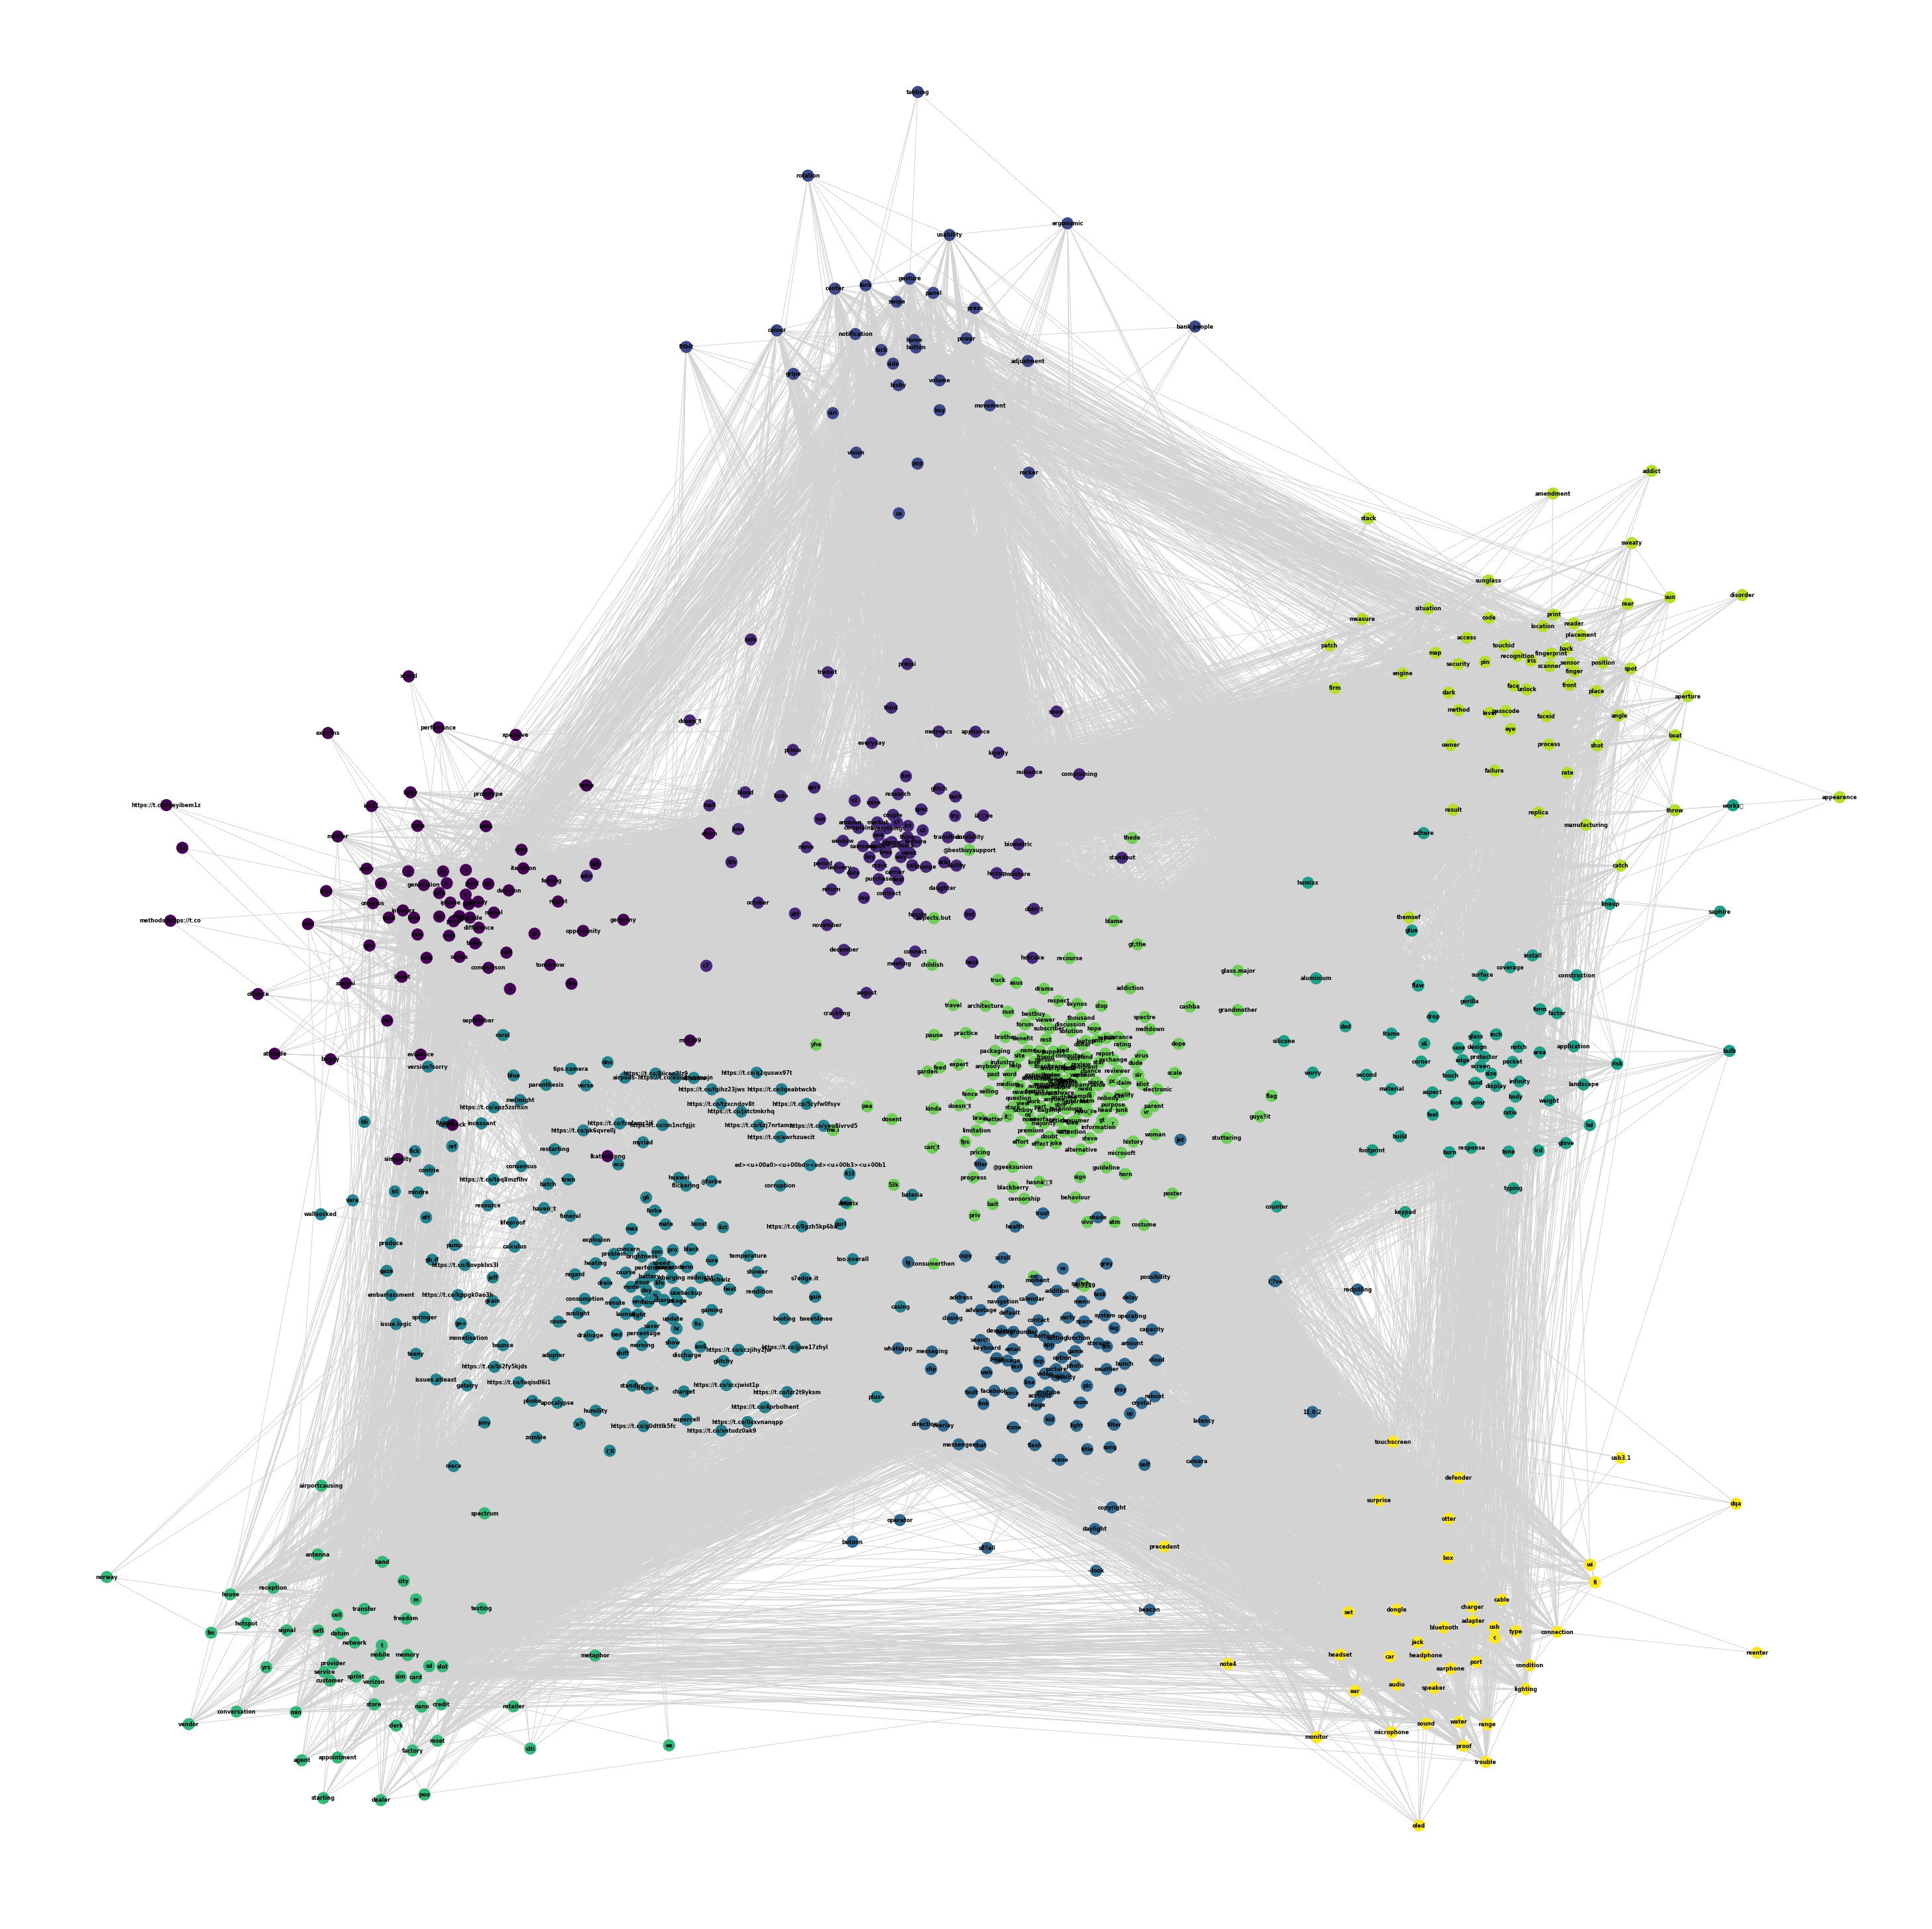

In [24]:
from community import community_louvain

#Nodes around 'problem'
matplotlib.rcParams['figure.figsize'] = (40, 40)
G=nx.ego_graph(G=graph_of_words, radius=1, n='problem')
partition = community_louvain.best_partition(G)
pos = community_layout(g=G, partition=partition)
nx.draw(G, pos, node_color=list(partition.values()), 
        labels=dict((n,n) for n,d in G.nodes(data=True)), font_color='black', font_size=8, font_weight='bold',
       edge_color='lightgray')

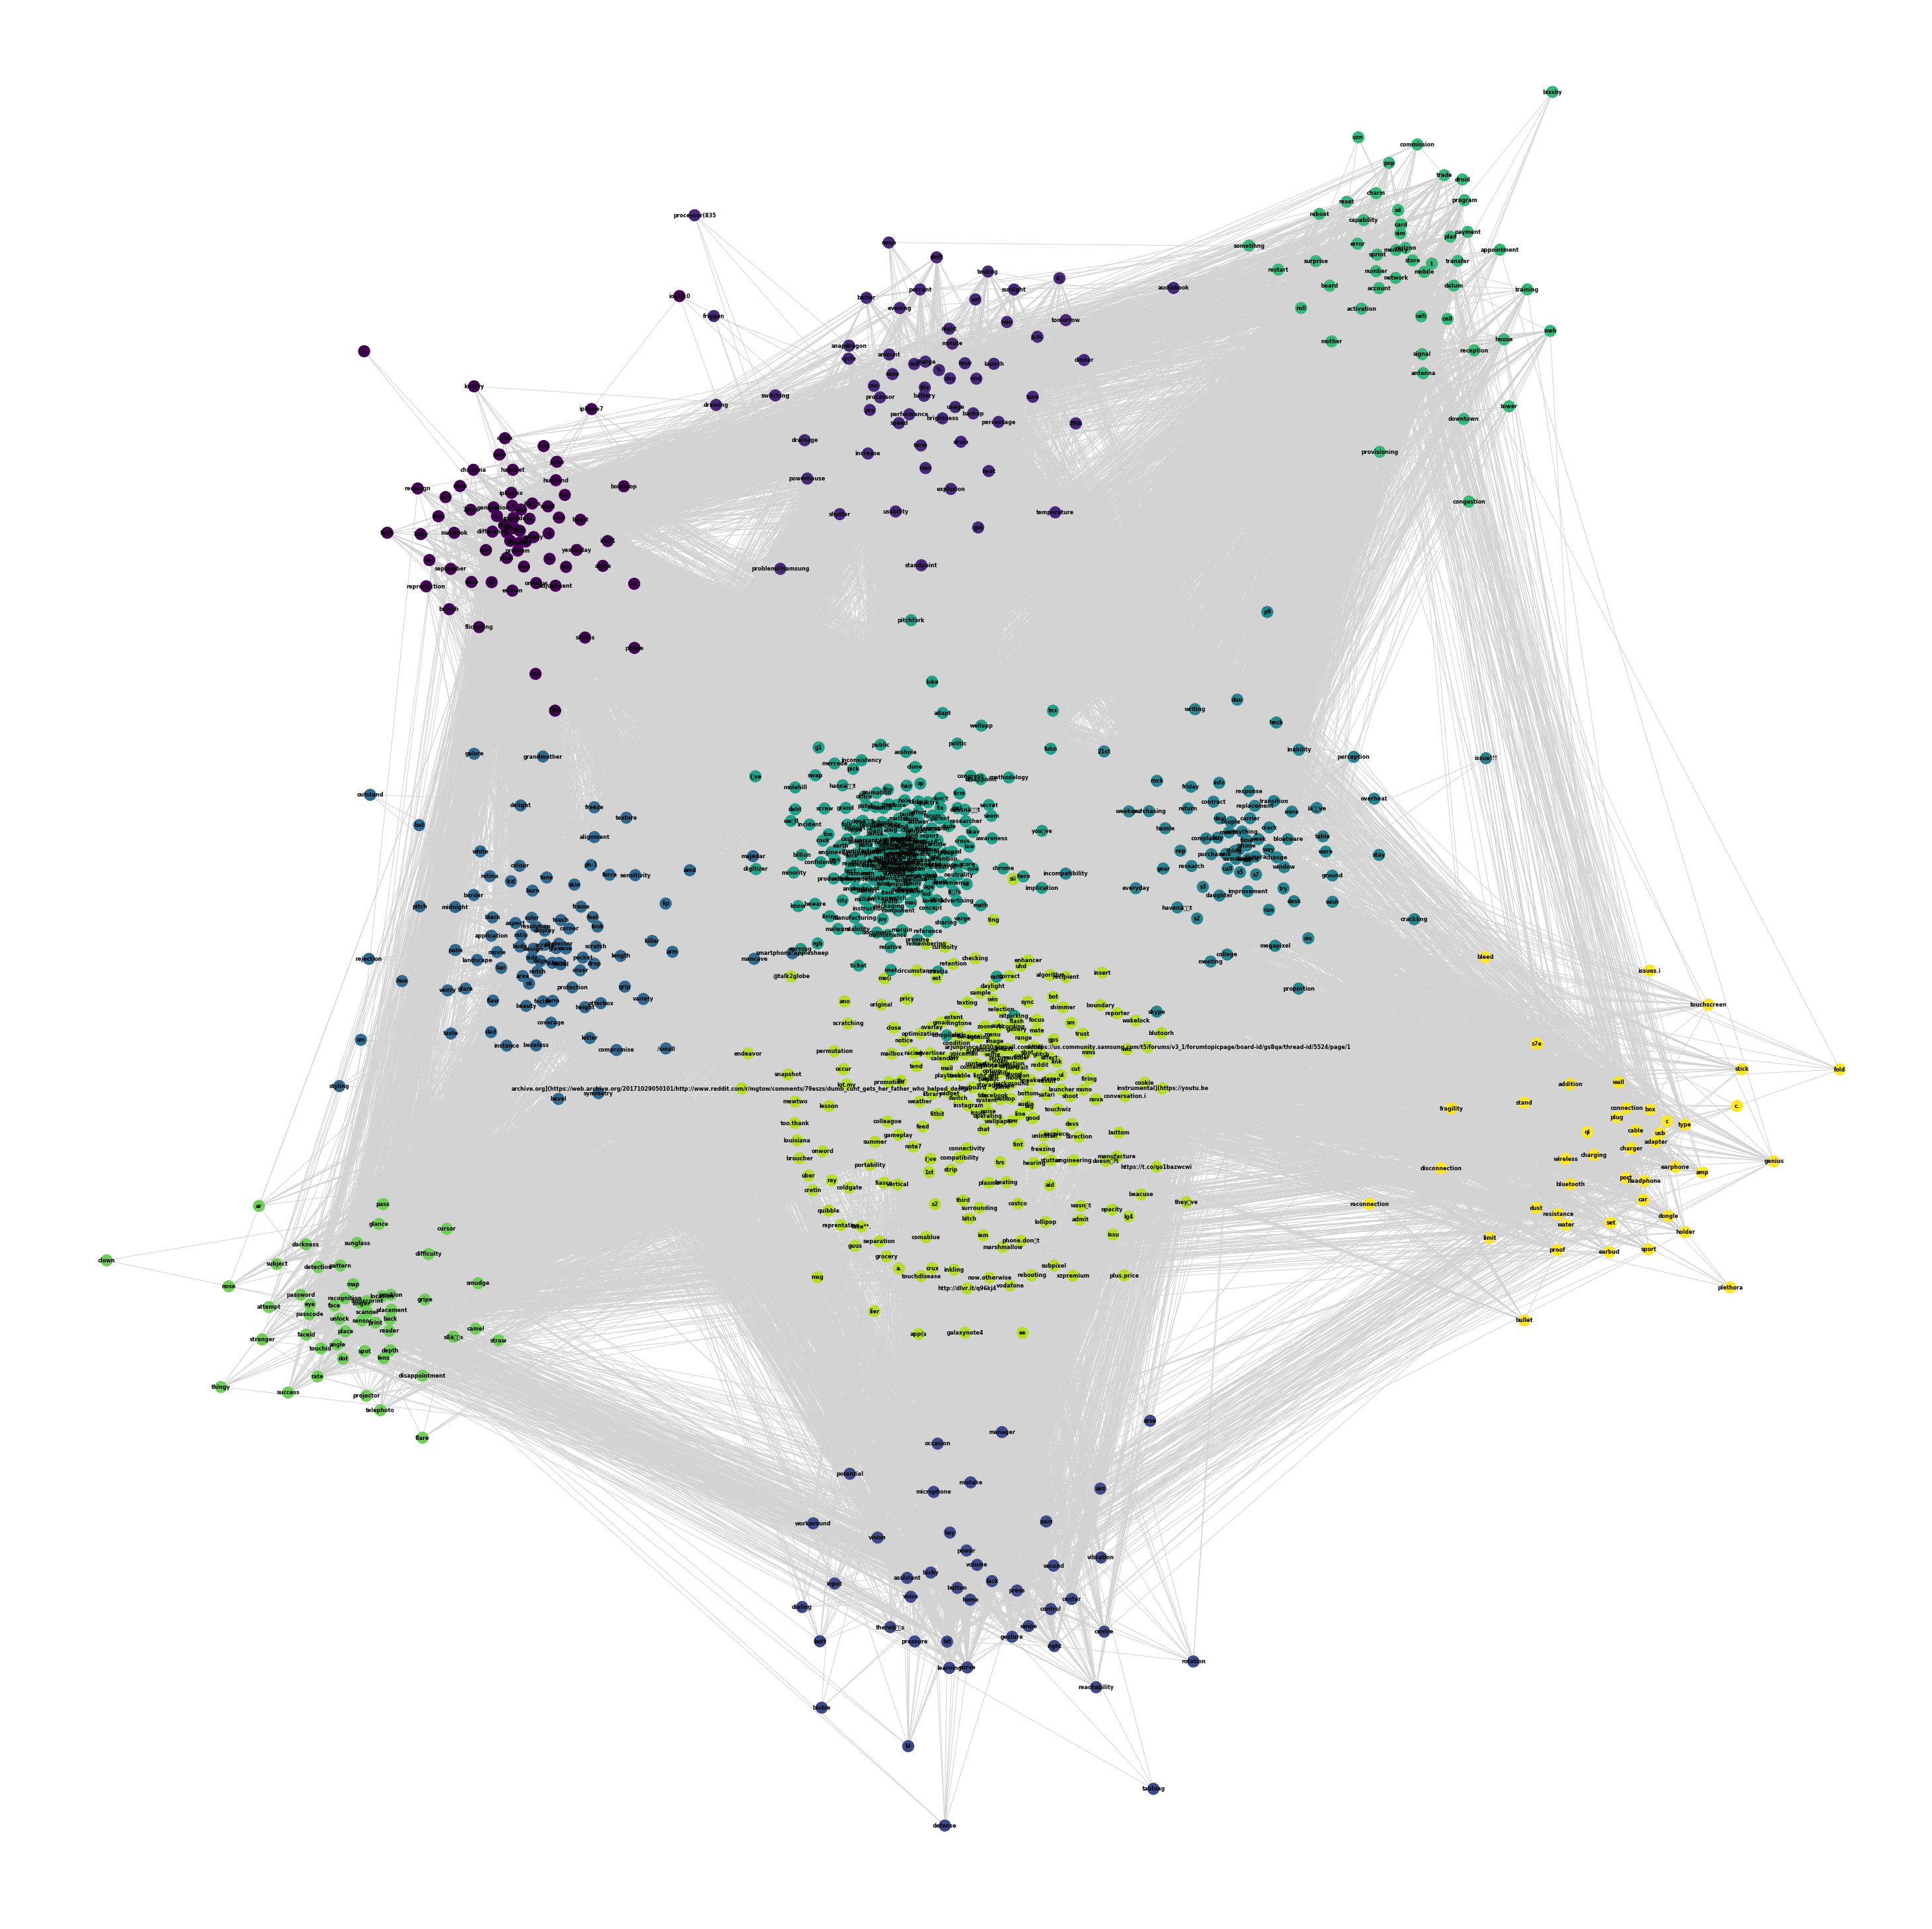

In [25]:
# Nodes around 'issue'
G=nx.ego_graph(G=graph_of_words, radius=1, n='issue')
partition = community_louvain.best_partition(G)
pos = community_layout(g=G, partition=partition)
matplotlib.rcParams['figure.figsize'] = (40, 40)
nx.draw(G, pos, node_color=list(partition.values()), 
        labels=dict((n,n) for n,d in G.nodes(data=True)), font_color='black', font_size=8, font_weight='bold',
       edge_color='lightgray')